# Confidence of a Bayesian Neural Network
This notebook examines the confidence calculation of a *Bayesian* neural network. I will use the *MNIST* and *FashionMNIST* datasets to demonstrate how confidence within the prediction process can help to avoid misclassification. `PyTorch` and `Pyro` are used for the probabilistic programming part.

## Approximate Bayesian Inference
Before we start to implement the *Bayesian* neural network lets have a look at the theory behind *Approximate Bayesian Inference*. 
#### Bayesian inference
The *prior* $p(\theta)$ is our prior believe of the (probability) distribution of the parameters $\theta$, which we have to identify first.

The *likelihood* $p(y_{1:N} | \theta)$ tells us, how our data $y$ interacts with / relates to our parameter $\theta$ for $N$ data points.

**Model:** The *likelihood* and the *prior* makes the model! This tells us how we can simulate from our data.

The *prior* as a marginal and the *likelihood* as a conditional together makes a *joined distribution* $p(y_{1:N},\theta)$.

$p(y | \theta) \: p(\theta) = p(y,\theta)$

This joined distribution can be also written as $p(\theta, y) = p(\theta | y) p(y)$

Which gives us $p(\theta | y) = \frac{p(\theta, y)}{p(y)}$. This is equivalent to 

$$p(\theta | y_{1:N}) = \frac{p(y_{1:N} | \theta) p(\theta)}{p(y_{1:N})}$$ 

which is called the ***Bayes Theorem***.

$p(y_{1:N})$ is the normalizing constant and is called the *evidence*. It is the probability of the data. It is the marginal of the joined probability $p(\theta , y)$ with $\theta$ integrated out. Therefore it can be written as: $\int p(y_{1:N} | \theta) \: p(\theta) \: d\theta$

$p(\theta | y_{1:N})$ is called the *posterior* and is exactly what we want to infer by Bayesian Inference.

Finally the Bayes Theorem can be written as: $$p(\theta | y_{1:N}) = \frac{p(y_{1:N} | \theta) p(\theta)}{\int p(y_{1:N} | \theta) p(\theta)d\theta}$$

Due to the possibly high dimension of $\theta$ and therefore the high dimensionality of the *posterior* we want to reduce our result to a point estimate and a notion of its distribution / uncertainty. This is mostly the *mean* and its *(co)variance*.

**Goal of Bayesian inference:** The goal of Bayesian inference is calculating the *posterior* and presenting a *mean* and a *(co)variance* of the calculated distribution $p(\theta | y_{1:N})$.

#### Problems of the Bayes Theorem
1. High dimensional integration of $\theta$ over the *evidence* to get the *posterior*. 
2. High dimensional integration of $\theta$ over the *posterior* to get a posterior *mean* and *(co)variance*.

Because of the intractability of the high dimensional integrations mentioned above the question is how do we get a *posterior* and its *mean* and *(co)variance* if we cannot calculate it directly?

*Approximate Bayesian Inference* it the solution to this problem.

#### Approximate the *posterior* by using Variational Bayes
If we cannot calculate the *posterior* we are going to approximate it by using *Variational Bayes*, which is an optimization approach. 

We denote the "optimal" approximated *posterior* by $q^*$. An "optimal" approximated *posterior* is the closest $q$ to the exact *posterior* $p(\theta|y)$ for which we can calculate a *mean* and *(co)variance*. (Remember our goal is to calculate / approximate a *mean* and *(co)variance* as our result.) 
<br><br>
<!-- <figure>
    <img src='pictures/variational-bayes.png' width=400 />
    <figcaption>Caption goes here</figcaption>
</figure>
 -->
<!-- <figure>
    <img src='../pictures/variational-bayes.png' width=400 align=left />
    <div style='width: 400px; text-align: center;'>Tamara Broderick - Tutorial "Variational Bayes and beyond: Bayesian inference for big data" - ICML 2018.</div>
</figure> -->

<img src='../pictures/variational-bayes.png' width=400 align=left />

<div style='width: 400px; text-align: center;'>Tamara Broderick - Tutorial "Variational Bayes and beyond: Bayesian inference for big data" - ICML 2018.</div>

In the case of *Variational Bayes* $q^*$ is: $$q^* = argmin_{q\in Q} KL(q(\theta) \parallel p(\theta | y))$$

where KL is the *Kullback-Leibler (KL)* divergence and $Q$ is the bulk of appropriate or "nice" distributions for which we can calculate the *mean* and the *variance*.

#### Advantage of using KL divergence
Lets look at the definition of the KL divergence:

$$ KL(q(\theta) \parallel p(\theta | y) := \int q(\theta) \: log \: \frac{q(\theta)}{p(\theta|y)} \: d\theta$$

where $q(\theta)$ is the approximating distribution and $p(\theta|y)$ is the exact *posterior* we want to approximate. 

Now the problem with the KL divergence is that we do not know the exact *posterior* so how can we approximate something that we don't know. To answer this question we need to do some algebraic manipulation and we start with replacing $p(\theta|y)$ in the denominator by $\frac {p(\theta, y)}{p(y)}$:

<!-- $$ KL(q(\theta) \parallel p(\theta | y) := \int q(\theta)\: log \: \frac{q(\theta)p(y)}{p(\theta,y)}\: d\theta$$ 
 -->

$$ KL(q(\theta) \parallel p(\theta | y) := \int q(\theta) \: log \frac{p(y)}{\frac{p(\theta,y)}{q(\theta)}} \: d\theta$$ 

now using the fact that $log\frac{a}{b} = log(a) - log(b)$ (quotient rule) we get:

$$ = \int q(\theta)\: (log \: p(y) - log \: \frac{p(\theta,y)}{q(\theta)})\:d\theta$$

$$ = \int q(\theta)\: log \: p(y)\: d\theta - \int q(\theta) log \: \frac{p(\theta,y)}{q(\theta)}\:d\theta$$

where $ \int q(\theta) \: log \, p(y) \: d(\theta)$ integrates to $log \, p(y)$ because $q$ is a distribution and therefore $\int q(\theta) \: d\theta$ integrates to $1$. So we get:

$$ = log\: p(y) - \int q(\theta)\: log \: \frac{p(\theta,y)}{q(\theta)}\:d\theta$$

The first term is the log of the evidence and does not contain $q$. As we are minimizing the KL divergence over $q$ this first term $log\: p(y)$ does not have any impact.

The second term is called *Evidence Lower Bound (ELBO)* and it contains only elements that we know. The joined distribution $p(\theta,y)$ is the *likelihood* times the *prior* and this is our input. This term can be optimized.

Due to the fact that the $KL \ge 0$ we have $log \, p(y) \ge ELBO$ and it is a lower bound for the $log$ of the *evidence*.

So now we have: 

$$q^* = argmin_{q\in Q} KL(q(\theta) \parallel p(\theta | y))$$ with 

$$ KL(q(\theta) \parallel p(\theta | y) := log\: p(y) - \int q(\theta)\: log \: \frac{p(\theta,y)}{q(\theta)}\:d\theta $$ 

and we get: 

$$q^* = argmax_{q \in Q} \,ELBO(q)$$

**Therefore minimizing the $KL$ divergence is equivalent to maximizing the $ELBO$.**

#### Conclusion
We started with the problem of minimizing the KL divergence between $q(\theta)$ and our exact *posterior* $p(\theta|y)$ which we don't know and ended up with maximizing the $ELBO$. This is the exact same problem with the benefit that we can solve it by optimization.


#### Mean-field Variational Bayes 

Last but not least we have to check what are appropriate or "nice", as called in the depiction above, distributions. As mentioned at the beginning of this explanation, we are looking for a *mean* and a *variance* and therefore we need distributions for which we can easily compute *means* and *variances*. This requirement is perfectly fulfilled by low dimensional, exponential distributions.

Starting with a high dimensional parameter vector $\theta$, we break it down into $J$ smaller components. Now the approximating distribution $q(\theta)$ factorizes over these $J$ components to calculate the approximation. This is the *Mean-field variational Bayes (MFVB)* assumption. 

$$Q_{MFVB} := \{ q : q(\theta) = \prod_{j=1}^J \: q_j(\theta_j)\}$$

Ideally $\theta$ factorizes into exponential distributions for whom it is easy to calculate *means* and *variances*.

#### Optimization

Now we apply optimization to find the optimal distribution $q^*$ which minimizes the $KL$ divergence between our appropriate distributions and the exact *posterior*. We are going to use *Stochastic Variational Inference (SVI)* for this purpose.  

# Probabilistic computation with Pyro

We will use [Pyro](https://pyro.ai/) for the probabilistic computation.

Import all necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from collections import OrderedDict

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import helper

In [2]:
# Pyro
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.set_rng_seed(101)

## Load the data

Use `Dataloader` to load the data and store it in the `data` directory.

The dataset is split into two parts, training and testing.

The testing sets is used to measure the model's performance on data it hasn't seen yet. 

Define how to transform the datasets.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

Define the datasets and where to store them.

In [4]:
# datasets
trainset = torchvision.datasets.MNIST('../data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('../data',
    download=True,
    train=False,
    transform=transform)

Load the datasets.

In [5]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Define the neural net. It is identical to the classic approach.

In [6]:
input_layer_size = 28*28 # image size of 28 x 28 pixels
hidden_layer_size = 1024 # number of hidden layer nodes
output_layer_size = 10   # number of categories

In [7]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.out = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.out(x)
        return x

In [8]:
log_softmax = nn.LogSoftmax(dim=1)

Instance new neural network for probabilistic calculations.

In [9]:
baysNeuralNet = NeuralNet(input_layer_size, hidden_layer_size, output_layer_size)

To do Bayesian inference in Pyro we need a *model*, a *guide*, an *optimizer*, and an *inference algorithm*.

### Model
In general a *model* in `Pyro` is a Python function which uses `Pyro` primitives (= primitive stochastic functions) to compute the input data.

One important thing to mention is that `pyro.sample` statements with an `obs` keyword are used to incorporate observations into the inference process. 

For Neural Networks we first need to convert our conventional network into a Bayesian network. Therefore we replace the fixed parameters for the weights and the biases by distributions. 

In our case we use the normal distribution to generate the priors.
```python
pyro.distributions.Normal()
```
After generating the priors, we replace the conventional, fixed parameters (weights and biases) by these new ones by calling 
```python
pyro.random_module()
```
Now we can create a sampled neural network module with sampled weights and biases and pass in data to generate a result.

In our case, the result will be 10 negative number representing the log probability of the 10 categories:

<img src='../pictures/mode-raw-output.png' width=700 align=left>

In [10]:
def model(x_data, y_data):
    
    # Initialize the prior distributions for the weights and biases of the neural network layers (N(0,1))
    fc1_weight_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.fc1.weight.size()), 
                        scale=torch.ones(baysNeuralNet.fc1.weight.size()))
    fc1_bias_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.fc1.bias.size()), 
                        scale=torch.ones(baysNeuralNet.fc1.bias.size()))

    
    out_weight_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.out.weight.size()), 
                        scale=torch.ones(baysNeuralNet.out.weight.size()))
    out_bias_prior = dist.Normal(loc=torch.zeros(baysNeuralNet.out.bias.size()), 
                        scale=torch.ones(baysNeuralNet.out.bias.size()))
    
    priors = {'fc1.weight': fc1_weight_prior, 'fc1.bias': fc1_bias_prior,  
              'out.weight': out_weight_prior, 'out.bias': out_bias_prior}
    
    # place a prior over the parameters (weights and biases) of the network. 
    # Returns a distribution (callable) over nn.Module`s, which upon calling returns a sampled `nn.Module.
    priored_module = pyro.random_module("module", baysNeuralNet, priors)
    
    # get a sampled `nn.Module (callable) with sampled weights and biases 
    sampled_module = priored_module()
    
    # get the LogSoftmax result for each dataset (within a batch)
    # each cathegory is represented by a negative number. (Eg 10 numbers for the 10 digits 0-9)
    logProbPred = log_softmax(sampled_module(x_data))
    
    # incorporate observations into the model
    # Call the stochastic function Categorical and return a sampled result according to the distribution if
    # no obs parameter is set to condition on - otherwise use the obs argument to the pyro.sample statement 
    # to condition on the observed data y_data -> the result will by y_data
    # Categorical creates a categorical distribution parameterized by logits (log_softmax())
    pyro.sample("obs", dist.Categorical(logits=logProbPred), obs=y_data)

The result of pyro.sample **without** the observation argument will be stochastically sampled from `logProbPred` and will be different from `y_data`:
<img src='../pictures/cat_sample_without_obs.png' width=800px>
The result of pyro.sample **with** the observation argument will be identical to `y_data`:
<img src='../pictures/cat_sample_with_obs.png' width=800px>

### Guide
The *guide* is a parameterized family of distributions over the *weights* and the *biases* and it is used to train the model by learning the parameters declared by `pyro.param` given the observation outcomes `obs`. `pyro.param` registers the parameters in the [ParamStore](http://docs.pyro.ai/en/0.2.1-release/parameters.html). 

The parameters to be learned are *fcl1_w_mu*, *fcl1_w_sigma*, *fcl1_b_mu*, *fcl1_b_sigma*, *outl_w_mu*, *outl_w_sigma*, *outl_b_mu* and *outl_b_sigma* and are defined within the *guide*. 

In [11]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1_weight_loc = torch.randn(baysNeuralNet.fc1.weight.size())
    fc1_weight_scale = torch.randn(baysNeuralNet.fc1.weight.size())
    fc1_weight_loc_param = pyro.param("fc1_weight_loc", fc1_weight_loc)
    fc1_weight_scale_param = softplus(pyro.param("fc1_weight_scale", fc1_weight_scale))
    fc1_weight_prior = dist.Normal(loc=fc1_weight_loc_param, scale=fc1_weight_scale_param)
    
    # First layer bias distribution priors
    fc1_bias_loc = torch.randn(baysNeuralNet.fc1.bias.size())
    fc1_bias_scale = torch.randn(baysNeuralNet.fc1.bias.size())
    fc1_bias_loc_param = pyro.param("fc1_bias_loc", fc1_bias_loc)
    fc1_bias_scale_param = softplus(pyro.param("fc1_bias_scale", fc1_bias_scale))
    fc1_bias_prior = dist.Normal(loc=fc1_bias_loc_param, scale=fc1_bias_scale_param)
    
    # Output layer weight distribution priors
    out_weight_loc = torch.randn(baysNeuralNet.out.weight.size())
    out_weight_scale = torch.randn(baysNeuralNet.out.weight.size())
    out_weight_loc_param = pyro.param("out_weight_loc", out_weight_loc)
    out_weight_scale_param = softplus(pyro.param("out_weight_scale", out_weight_scale))
    out_weight_prior = dist.Normal(loc=out_weight_loc_param, scale=out_weight_scale_param).independent(1)
    
    # Output layer bias distribution priors
    out_bias_loc = torch.randn(baysNeuralNet.out.bias.size())
    out_bias_scale = torch.randn(baysNeuralNet.out.bias.size())
    out_bias_loc_param = pyro.param("out_bias_loc", out_bias_loc)
    out_bias_scale_param = softplus(pyro.param("out_bias_scale", out_bias_scale))
    out_bias_prior = dist.Normal(loc=out_bias_loc_param, scale=out_bias_scale_param)
    
    priors = {'fc1.weight': fc1_weight_prior, 'fc1.bias': fc1_bias_prior, 
              'out.weight': out_weight_prior, 'out.bias': out_bias_prior}
    
    priored_module = pyro.random_module("module", baysNeuralNet, priors)
    
    return priored_module()

### Optimizer & Inference Algorithm
In this example we use the *Adam* optimizer and the *Stochastic Variational Inference (SVI)*.

In [12]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

### Training
Training is done by the *Stochastic Variational Inference (SVI)* optimization algorithm with the *ELBO* as the loss function (See the introductory part at the beginning of this notebook) by adjusting the `pyro.param` values.

In [13]:
num_iterations = 10
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(trainloader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(trainloader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j+1, " Loss ", total_epoch_loss_train)

/home/horst/anaconda3/envs/pyro/lib/python3.6/site-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  1  Loss  2106.8290526576043
Epoch  2  Loss  378.6769510138989
Epoch  3  Loss  161.66674293100039
Epoch  4  Loss  112.00966752870877
Epoch  5  Loss  97.43290654851596
Epoch  6  Loss  90.94613541169167
Epoch  7  Loss  87.42377650856972
Epoch  8  Loss  86.76962037156423
Epoch  9  Loss  86.66487224982579
Epoch  10  Loss  85.86500588234266


### Testing the Bayesian neural network
In contrast to classical neural network with fixed parameters, Bayesian neural network with its random parameters need multiple runs / forwardpasses for a single input to predict an output. For an identical input file, each run will generate a different output. This is due to the randomness of the *weights* and *biases* of the Bayesian neural network. This is displayed in the following drawing from [Blundell et al](https://arxiv.org/pdf/1505.05424.pdf)

<img src='../pictures/Blundell_1.png' width=600 align=left />

<div style='width: 600px; text-align: center;'>Blundell et al.</div>

On the left you can see a classical neural net with fixed *weights* and *biases* and on the right side you can see a Bayesian neural net with its random parameters.

Therefore you need multiple runs to calculate the outcome.

In the implementation below we use the *guide()* for prediction because it has the trained parameters.
1. The first statement within *prediction()* generates *num_of_samples* Bayesian networks
2. The second statement generates *num_of_samples* predictions for each single input. Thus if we have a test batch size of 64 we get in total 640 predictions, 10 for each input.
3. The forth statement calculates the mean / average over the *num_of_samples* output for each input and each category. Thus yielding in 64 tensors with a mean value for each category.
4. The result is the index of the category with the maximal mean value. There is one value for each input.

In [14]:
# number of multiple runs for a single input
num_of_samples = 100

def predict(x):
    # generate num_of_samples models 
    sampled_models = [guide(None, None) for _ in range(num_of_samples)]
    # forwardpass of the date -> generates num_of_samples predictions per input
    yhats = [model(x).data for model in sampled_models]
    # stack the tensors for further processing
    inter = torch.stack(yhats)
    # Build the mean value for each category out of the sampled models
    mean = torch.mean(inter, 0)
    # Build the variance for each category out of the sampled models
    variance = torch.var(inter, 0)
    # get the category with the maximal mean value
    # this is the predicted value of the Bayesian natwork
    res = np.argmax(mean.numpy(), axis=1)
    return res

print('Predict everey input without confidence estimation')
correct = 0
total = 0
for j, data in enumerate(testloader):
    images, labels = data
    with torch.no_grad():
        predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += np.equal(predicted, labels).sum()
print("Accuracy: {:.1f} %".format(correct / total * 100))

Predict everey input without confidence estimation
Accuracy: 91.4 %


### Variance of each category
The following function `calculate_variance()` calculates the predicted variance of each category. 
1. For one input make `num_of_samples` forward passes through `num_of_samples` different models.
2. Calculate the variance for each category over the `num_of_samples` results.
3. Calculate a mean variance of the category variances.
4. "Normalize" each category variance with the mean variance.
5. Extract the minimal normalized category variance and return it.
6. Extract the category with the minimal normalized category variance and return it.

In [15]:
# number of multiple runs for a single input
num_of_samples = 100

def calculate_variance(x):
    # generate num_of_samples models 
    sampled_models = [guide(None, None) for _ in range(num_of_samples)]
    
    # calculate the log softmax probability for the input images
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).numpy() for model in sampled_models]
    
    # 1. Convert yhat into an array -> np.asarray()
    # 2. Join the sequence of arrays along axis 1 -> np.stack
    # 3. Calculet the variance along axis 1 for each category out of the num_of_samples results-> np.var
    var_yhat = np.var(np.stack(np.asarray(yhats), 1), 1)
    
    # Average the variences
    mean_var = np.mean(var_yhat, 1)
    
    interm = []
    for i in range(len(mean_var)):
        interm.append(var_yhat[i] / mean_var[i])
    
    # Array of the normalized categy variances 
    normalized_var = np.array(interm)
    
    # Get the minimal categorical value
    min_var = np.min(normalized_var, 1)
    
    # Get the index (the category) with the minimal value
    min_var_item = np.argmin(normalized_var, 1)
    
    # Return the minimal normelized categary variance and the corresponding category
    return min_var, min_var_item

Test procedure

In [16]:
def test_var_batch(images, labels, plot=True):
    min_var, min_var_item = calculate_variance(images)
    predicted_for_images = 0
    correct_predictions = 0
    normalized_var_threshold = 0.2

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
    
        highted_something = False
        
        if(plot):
            plt.show()
    
        if min_var[i] < normalized_var_threshold:
            highted_something = True
            predicted = min_var_item[i]
            
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect")
        else:
            if(plot):
                print("Undecided.")
        if(plot):
                print("Normalized Variance = {:.5f} for threshold = {:.2f}"
                      .format(min_var[i], normalized_var_threshold))
        if(plot):
            helper.small_imshow(images[i].squeeze())
        
    
    if(plot):
        print("\n\nSummary")
        print("Number of images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 

Run the test procedure with the `MNIST` test set.

Real:  7
Correct
Normalized Variance = 0.00018 for threshold = 0.20


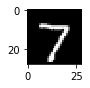

Real:  2
Undecided.
Normalized Variance = 0.28286 for threshold = 0.20


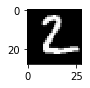

Real:  1
Correct
Normalized Variance = 0.00066 for threshold = 0.20


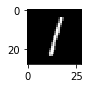

Real:  0
Correct
Normalized Variance = 0.00268 for threshold = 0.20


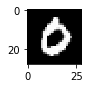

Real:  4
Correct
Normalized Variance = 0.08007 for threshold = 0.20


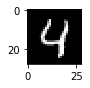

Real:  1
Correct
Normalized Variance = 0.00855 for threshold = 0.20


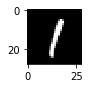

Real:  4
Correct
Normalized Variance = 0.06727 for threshold = 0.20


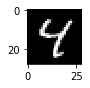

Real:  9
Undecided.
Normalized Variance = 0.39528 for threshold = 0.20


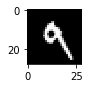

Real:  5
Undecided.
Normalized Variance = 0.26116 for threshold = 0.20


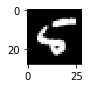

Real:  9
Correct
Normalized Variance = 0.19540 for threshold = 0.20


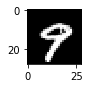

Real:  0
Correct
Normalized Variance = 0.00285 for threshold = 0.20


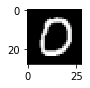

Real:  6
Undecided.
Normalized Variance = 0.34354 for threshold = 0.20


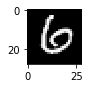

Real:  9
Correct
Normalized Variance = 0.10465 for threshold = 0.20


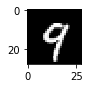

Real:  0
Correct
Normalized Variance = 0.00226 for threshold = 0.20


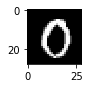

Real:  1
Correct
Normalized Variance = 0.00182 for threshold = 0.20


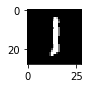

Real:  5
Correct
Normalized Variance = 0.13148 for threshold = 0.20


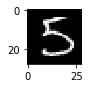

Real:  9
Correct
Normalized Variance = 0.19621 for threshold = 0.20


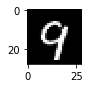

Real:  7
Correct
Normalized Variance = 0.01827 for threshold = 0.20


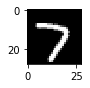

Real:  3
Undecided.
Normalized Variance = 0.63642 for threshold = 0.20


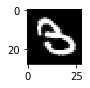

Real:  4
Correct
Normalized Variance = 0.00101 for threshold = 0.20


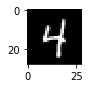

Real:  9
Correct
Normalized Variance = 0.19190 for threshold = 0.20


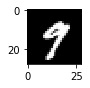

Real:  6
Correct
Normalized Variance = 0.01074 for threshold = 0.20


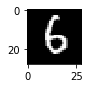

Real:  6
Undecided.
Normalized Variance = 0.30285 for threshold = 0.20


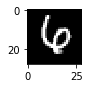

Real:  5
Correct
Normalized Variance = 0.04898 for threshold = 0.20


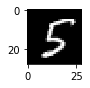

Real:  4
Correct
Normalized Variance = 0.02168 for threshold = 0.20


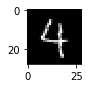

Real:  0
Correct
Normalized Variance = 0.00035 for threshold = 0.20


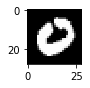

Real:  7
Correct
Normalized Variance = 0.02834 for threshold = 0.20


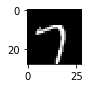

Real:  4
Correct
Normalized Variance = 0.01276 for threshold = 0.20


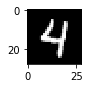

Real:  0
Correct
Normalized Variance = 0.00000 for threshold = 0.20


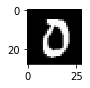

Real:  1
Correct
Normalized Variance = 0.08674 for threshold = 0.20


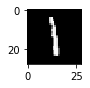

Real:  3
Correct
Normalized Variance = 0.10101 for threshold = 0.20


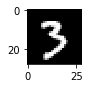

Real:  1
Correct
Normalized Variance = 0.10122 for threshold = 0.20


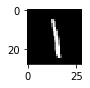

Real:  3
Undecided.
Normalized Variance = 0.26181 for threshold = 0.20


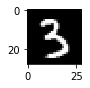

Real:  4
Undecided.
Normalized Variance = 0.57928 for threshold = 0.20


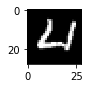

Real:  7
Correct
Normalized Variance = 0.04841 for threshold = 0.20


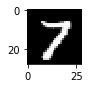

Real:  2
Correct
Normalized Variance = 0.03780 for threshold = 0.20


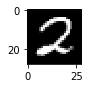

Real:  7
Correct
Normalized Variance = 0.02109 for threshold = 0.20


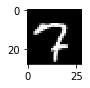

Real:  1
Correct
Normalized Variance = 0.02370 for threshold = 0.20


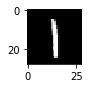

Real:  2
Undecided.
Normalized Variance = 0.35019 for threshold = 0.20


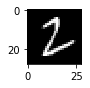

Real:  1
Correct
Normalized Variance = 0.00921 for threshold = 0.20


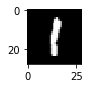

Real:  1
Correct
Normalized Variance = 0.00684 for threshold = 0.20


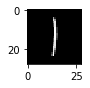

Real:  7
Correct
Normalized Variance = 0.06024 for threshold = 0.20


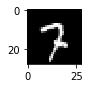

Real:  4
Correct
Normalized Variance = 0.04208 for threshold = 0.20


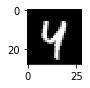

Real:  2
Undecided.
Normalized Variance = 0.54925 for threshold = 0.20


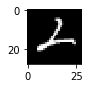

Real:  3
Undecided.
Normalized Variance = 0.34531 for threshold = 0.20


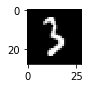

Real:  5
Correct
Normalized Variance = 0.10681 for threshold = 0.20


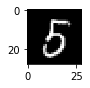

Real:  1
Undecided.
Normalized Variance = 0.42705 for threshold = 0.20


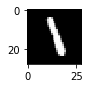

Real:  2
Correct
Normalized Variance = 0.12827 for threshold = 0.20


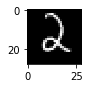

Real:  4
Correct
Normalized Variance = 0.01514 for threshold = 0.20


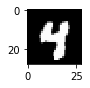

Real:  4
Correct
Normalized Variance = 0.01428 for threshold = 0.20


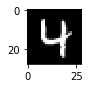

Real:  6
Correct
Normalized Variance = 0.00137 for threshold = 0.20


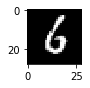

Real:  3
Correct
Normalized Variance = 0.16084 for threshold = 0.20


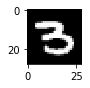

Real:  5
Correct
Normalized Variance = 0.13621 for threshold = 0.20


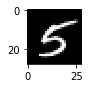

Real:  5
Correct
Normalized Variance = 0.06117 for threshold = 0.20


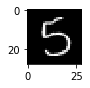

Real:  6
Correct
Normalized Variance = 0.13872 for threshold = 0.20


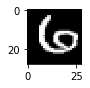

Real:  0
Correct
Normalized Variance = 0.07779 for threshold = 0.20


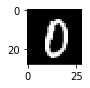

Real:  4
Correct
Normalized Variance = 0.00481 for threshold = 0.20


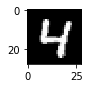

Real:  1
Correct
Normalized Variance = 0.02062 for threshold = 0.20


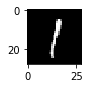

Real:  9
Undecided.
Normalized Variance = 0.21587 for threshold = 0.20


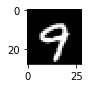

Real:  5
Correct
Normalized Variance = 0.10746 for threshold = 0.20


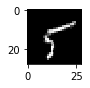



Summary
Number of images:  60
Predicted for:  47
Accuracy when predicted:  1.0


(60, 47.0, 47)

In [17]:
images, labels = next(iter(testloader))
test_var_batch(images[:60], labels[:60])

### Out-of-distribution test
Load the `FashionMNIST` test set to perform an out-of-distribution test. 

In [18]:
# FashionMNIST test dataset
fashiontestset = torchvision.datasets.FashionMNIST('../data',
    download=True,
    train=False,
    transform=transform)

In [19]:
fashiontestloader = torch.utils.data.DataLoader(fashiontestset, batch_size=64, shuffle=False)

Run the test procedure with the `FashionMNIST` test set.

Real:  9
Undecided.
Normalized Variance = 0.23574 for threshold = 0.20


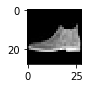

Real:  2
Undecided.
Normalized Variance = 0.55965 for threshold = 0.20


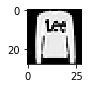

Real:  1
Undecided.
Normalized Variance = 0.60028 for threshold = 0.20


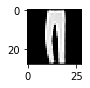

Real:  1
Undecided.
Normalized Variance = 0.58490 for threshold = 0.20


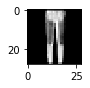

Real:  6
Undecided.
Normalized Variance = 0.64343 for threshold = 0.20


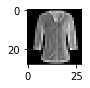

Real:  1
Undecided.
Normalized Variance = 0.66663 for threshold = 0.20


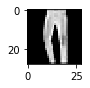

Real:  4
Undecided.
Normalized Variance = 0.69063 for threshold = 0.20


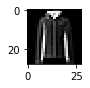

Real:  6
Undecided.
Normalized Variance = 0.72726 for threshold = 0.20


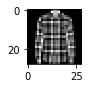

Real:  5
Incorrect
Normalized Variance = 0.07923 for threshold = 0.20


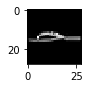

Real:  7
Incorrect
Normalized Variance = 0.13874 for threshold = 0.20


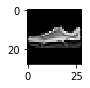

Real:  4
Undecided.
Normalized Variance = 0.66239 for threshold = 0.20


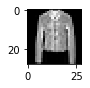

Real:  5
Undecided.
Normalized Variance = 0.46556 for threshold = 0.20


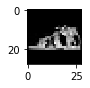

Real:  7
Undecided.
Normalized Variance = 0.38502 for threshold = 0.20


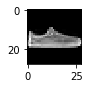

Real:  3
Undecided.
Normalized Variance = 0.36867 for threshold = 0.20


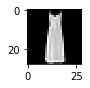

Real:  4
Undecided.
Normalized Variance = 0.65871 for threshold = 0.20


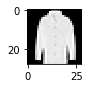

Real:  1
Undecided.
Normalized Variance = 0.50240 for threshold = 0.20


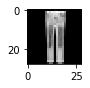

Real:  2
Undecided.
Normalized Variance = 0.68067 for threshold = 0.20


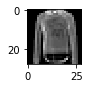

Real:  4
Undecided.
Normalized Variance = 0.72447 for threshold = 0.20


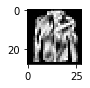

Real:  8
Undecided.
Normalized Variance = 0.69709 for threshold = 0.20


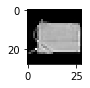

Real:  0
Undecided.
Normalized Variance = 0.50351 for threshold = 0.20


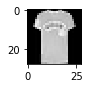

Real:  2
Undecided.
Normalized Variance = 0.72196 for threshold = 0.20


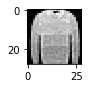

Real:  5
Undecided.
Normalized Variance = 0.45676 for threshold = 0.20


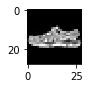

Real:  7
Undecided.
Normalized Variance = 0.34364 for threshold = 0.20


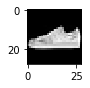

Real:  9
Undecided.
Normalized Variance = 0.76815 for threshold = 0.20


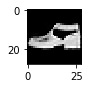

Real:  1
Undecided.
Normalized Variance = 0.59865 for threshold = 0.20


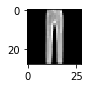

Real:  4
Undecided.
Normalized Variance = 0.61124 for threshold = 0.20


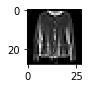

Real:  6
Undecided.
Normalized Variance = 0.61861 for threshold = 0.20


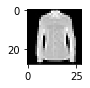

Real:  0
Undecided.
Normalized Variance = 0.36714 for threshold = 0.20


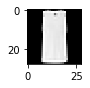

Real:  9
Incorrect
Normalized Variance = 0.14332 for threshold = 0.20


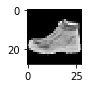

Real:  3
Undecided.
Normalized Variance = 0.37280 for threshold = 0.20


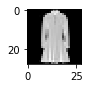

Real:  8
Undecided.
Normalized Variance = 0.79248 for threshold = 0.20


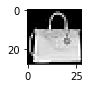

Real:  8
Undecided.
Normalized Variance = 0.57454 for threshold = 0.20


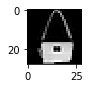

Real:  3
Undecided.
Normalized Variance = 0.61221 for threshold = 0.20


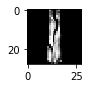

Real:  3
Undecided.
Normalized Variance = 0.22776 for threshold = 0.20


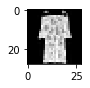

Real:  8
Undecided.
Normalized Variance = 0.45422 for threshold = 0.20


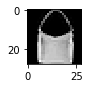

Real:  0
Undecided.
Normalized Variance = 0.55947 for threshold = 0.20


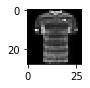

Real:  7
Undecided.
Normalized Variance = 0.22698 for threshold = 0.20


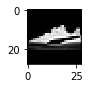

Real:  5
Incorrect
Normalized Variance = 0.02328 for threshold = 0.20


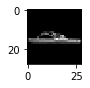

Real:  7
Incorrect
Normalized Variance = 0.08408 for threshold = 0.20


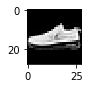

Real:  9
Incorrect
Normalized Variance = 0.14315 for threshold = 0.20


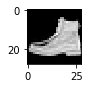

Real:  6
Undecided.
Normalized Variance = 0.27566 for threshold = 0.20


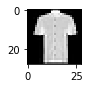

Real:  1
Undecided.
Normalized Variance = 0.45511 for threshold = 0.20


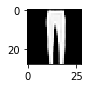

Real:  3
Undecided.
Normalized Variance = 0.43729 for threshold = 0.20


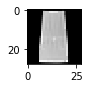

Real:  7
Incorrect
Normalized Variance = 0.12071 for threshold = 0.20


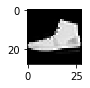

Real:  6
Undecided.
Normalized Variance = 0.61797 for threshold = 0.20


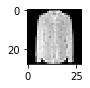

Real:  7
Undecided.
Normalized Variance = 0.44507 for threshold = 0.20


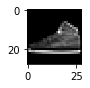

Real:  2
Undecided.
Normalized Variance = 0.64366 for threshold = 0.20


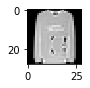

Real:  1
Undecided.
Normalized Variance = 0.56121 for threshold = 0.20


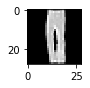

Real:  2
Undecided.
Normalized Variance = 0.67563 for threshold = 0.20


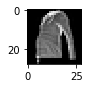

Real:  2
Undecided.
Normalized Variance = 0.66464 for threshold = 0.20


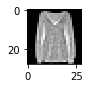

Real:  4
Undecided.
Normalized Variance = 0.65854 for threshold = 0.20


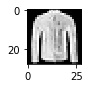

Real:  4
Undecided.
Normalized Variance = 0.61993 for threshold = 0.20


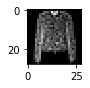

Real:  5
Undecided.
Normalized Variance = 0.20711 for threshold = 0.20


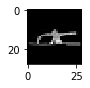

Real:  8
Undecided.
Normalized Variance = 0.59433 for threshold = 0.20


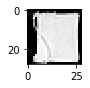

Real:  2
Undecided.
Normalized Variance = 0.62125 for threshold = 0.20


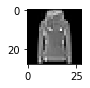

Real:  2
Undecided.
Normalized Variance = 0.65975 for threshold = 0.20


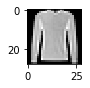

Real:  8
Undecided.
Normalized Variance = 0.67823 for threshold = 0.20


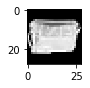

Real:  4
Undecided.
Normalized Variance = 0.61884 for threshold = 0.20


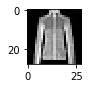

Real:  8
Undecided.
Normalized Variance = 0.82367 for threshold = 0.20


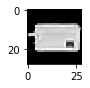

Real:  0
Undecided.
Normalized Variance = 0.54218 for threshold = 0.20


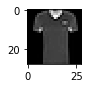



Summary
Number of images:  60
Predicted for:  7
Accuracy when predicted:  0.0


(60, 0, 7)

In [20]:
images, labels = next(iter(fashiontestloader))
test_var_batch(images[0:60], labels[0:60])

### Results of the test procedure for `MNIST` and `FashionMNIST`
The results above illustrate the intention behind the confidence calculation. For the `MNIST` data the confidence calculation leads the an accuracy of 100 % and the algorithm was confident at around 80 % of the input images. It detected 20 % of the input images not as digits and therefore the **false negative** (type 2 error) rate for this test is 20 %.

On the other hand, it detected 88 % an non-digits for the `FashionMNIST` data set. Therefore the **false positive** (type 1 error) rate is 12 %.

In [21]:
# Prediction after confidence estimation

print('Prediction after confidence estimation')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(testloader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_var_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: {:3.1f}".format (100 * correct / total_predicted_for))

Prediction after confidence estimation
Total images:  10000
Skipped:  2671
Accuracy when made predictions: 98.5


## Conclusion and future improvements 
The accuracy after confidence estimation is 98.5 % and therefore an improvement of 7.1 % compared to the prediction without confidence estimation. But the rate of the *false negative* or *type 2* errors for confidence estimation is pretty high with 26.71 %. Thus it is important to lower the type 2 error rate of the confidence estimation by keeping the accuracy as high as possible. 

#### Possible technical improvements
1. average the variance over all but the smallest values.
2. Calculate the distance between the smallest and the second smallest value.
3. Take multiple runs (eg. 5) and average over them.

## References
[[1]](https://www.youtube.com/watch?v=DYRK0-_K2UU&feature=youtu.be) Tamara Broderick - Tutorial "Variational Bayes and beyond: Bayesian inference for big data" - ICML 2018.
<br>
[[2]](https://arxiv.org/pdf/1505.05424.pdf) C. Blundell, J. Cornebise, K. Kavukcuoglu, and D. Wierstra, “Weight uncertainty in neural networks,” in *International Conference on Machine Learning*, 2015, pp. 1613–1622.
<br>
[[3]](https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd) Paras Chopra, "Making Your Neural Network Say “I Don’t Know” — Bayesian NNs using Pyro and PyTorch" in *towards data science*, 2018